In [2]:
# Libraries
import gpflow
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import waveome

## Data Preparation

In [2]:
# Data Read
mbx = pd.read_csv('../iHMP/data/iHMP_labeled_metabolomics.csv', low_memory=False)
mtd = pd.read_csv('../iHMP/data/iHMP_metadata.csv', low_memory=False)

# Print out sizes

# Clean up
# Save separate lookup table
mbx_lookup = mbx[['HMDB (*Representative ID)', 'Metabolite', 'Compound']]
mbx = (
    mbx
    # Drop all column identifiers that aren't necessary for search
    .drop(columns=mbx.columns[:6])
    # Prepare to transpose dataframe
    .set_index('Compound')
    # Make sure we have observation (row) by metabolite (column)
    .transpose()
    # Pull off index for matching
    .reset_index(names='External ID')
    # Impute zero for missing intensity value
    .fillna(0.)
    .set_index('External ID')
    .sort_index()
)
mbx

Compound,C18n_QI06,C18n_QI07,C18n_QI08,C18n_QI09,C18n_QI10,C18n_QI11,C18n_TF1,C18n_QI12,C18n_QI13,C18n_QI14,...,HILp_QI13155,HILp_TF17,HILp_TF35,HILp_TF19,HILp_QI25304,HILp_TF2,HILp_TF3,HILp_TF12,HILp_QI23736,HILp_QI24373
External ID,,,,,,,,,,,,,,,,,,,,,
CSM5FZ3N,942546.0,1418451.0,2194.0,0.0,38180.0,5893.0,0.0,4174.0,211440.0,15667.0,...,19777461.0,9997928.0,3579319.0,2066660.0,86595.0,274385476.0,136360623.0,2.119068e+08,36328.0,586321.0
CSM5FZ3T,470132.0,416924.0,28.0,0.0,11781.0,6345.0,0.0,5257.0,29713.0,2833.0,...,34863534.0,69914375.0,6996249.0,15657037.0,1162223.0,70872089.0,5868952.0,3.456104e+09,119223.0,3284388.0
CSM5FZ44,720369.0,1198835.0,436.0,0.0,8721.0,14372.0,0.0,5462.0,86293.0,64553.0,...,15526303.0,12300553.0,1812524.0,7134468.0,95476.0,90077297.0,10050253.0,9.373580e+08,0.0,323194.0
CSM5FZ48,1069292.0,1256069.0,773.0,0.0,62098.0,5653.0,0.0,3628.0,9523.0,18466.0,...,14346185.0,14010937.0,4867731.0,17058734.0,0.0,250558333.0,238294493.0,3.669375e+08,36710.0,885943.0
CSM5FZ4A,1265301.0,1368667.0,542.0,0.0,3235743.0,10058.0,0.0,5165.0,25482.0,9282.0,...,32308733.0,11756268.0,4435431.0,5256579.0,80735.0,6695543.0,872027.0,5.998712e+08,13503.0,1555485.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PSMA26A3,380042.0,320397.0,1008.0,0.0,108669.0,11948.0,499437.0,3172.0,10599.0,12693.0,...,3250546.0,5144501.0,1554451.0,197869363.0,0.0,34836268.0,22973938.0,3.254163e+09,13148.0,2717657.0
PSMA26AJ,2930386.0,2661474.0,178.0,0.0,22508.0,4892.0,0.0,2441.0,42024.0,7902.0,...,7154808.0,9858268.0,0.0,11257588.0,2302.0,145032134.0,80538278.0,6.841049e+08,0.0,231075.0
PSMB4MBK,494213.0,634210.0,193.0,0.0,24374.0,4879.0,0.0,4165.0,198330.0,10425.0,...,10419020.0,8170396.0,931220.0,6057583.0,0.0,10612065.0,6931891.0,1.519354e+09,0.0,191390.0


In [3]:
mbx_lookup

,HMDB (*Representative ID),Metabolite,Compound
0,HMDB04705,12.13-diHOME,C18n_QI06
1,HMDB04704,9.10-diHOME,C18n_QI07
2,HMDB00535,caproate,C18n_QI08
3,HMDB00666,heptanoate,C18n_QI09
4,HMDB00764,hydrocinnamate,C18n_QI10
...,...,...,...
591,HMDB00252*,sphingosine-isomer1,HILp_TF2
592,HMDB00252*,sphingosine-isomer2,HILp_TF3
593,HMDB00252*,sphingosine-isomer3,HILp_TF12
594,HMDB12097,C14:0 SM,HILp_QI23736


In [4]:
pd.set_option('display.max_columns', 500)
'''
Metadata column selection:
- External ID (sample ID)
- Participant ID (person ID)
- date_of_receipt
- site_name (location)
- Age at diagnosis 
- consent_age
- diagnosis
- General wellbeing
- Abdominal pain
- Number of liquid or very soft stools in the past 24 hours:
- Arthralgia (joint pain)
- hbi
- Hispanic or Latino Origin
- BMI
- Height
- Weight.1
- Cancer columns
- Subject was diagnosed within the last 6 months
- Age at diagnosis (A)
- race
- Blood in the stool
- General well being over the past 24 hours
- sccai
- sex
- smoking status
'''

column_list = [
    'External ID', 'Participant ID', 'site_name', 'Age at diagnosis',
    'consent_age', 'diagnosis', 'General wellbeing', 
    'hbi', 'Hispanic or Latino Origin', #'BMI',
    'date_of_receipt', 'race', 
    'General well being over the past 24 hours', 'sccai', 'sex',
]

# Now prepare metadata set
mtd_sub = (
    mtd
    .loc[mtd['data_type'].values == 'metabolomics', column_list]
    .rename(columns={
        'Participant ID': 'participant_id',
        'Age at diagnosis': 'age_at_diagnosis',
        'Hispanic or Latino Origin': 'hispanic'
    })
    .assign(disease_years = lambda x: x['consent_age'] - x['age_at_diagnosis'])
    .assign(study_days = lambda x: (
        pd.to_datetime(x['date_of_receipt']) 
        - pd.to_datetime(x['date_of_receipt']).min()
        ).dt.days.astype("float") #('timedelta64[D]')
    )
    .assign(age = lambda x: x['consent_age'] + (x['study_days']/365.))
    .assign(general_wellbeing = lambda x: x['General wellbeing'].combine_first(x['General well being over the past 24 hours']))
    .assign(severity = lambda x: np.where(x['diagnosis'] == 'CD', x['hbi'], x['sccai']))
    .assign(active_disease = lambda x: np.where(x['severity'] >= 5, '1', '0'))
    .assign()
    # .groupby('participant_id', as_index=False)
    # .assign(max_disease_date = lambda x: np.where(x['severity'] == x['severity'].max(), x['date_of_receipt'], np.nan))
    .drop(columns=[
        'General wellbeing', 'General well being over the past 24 hours',
        'hbi', 'sccai',
        'date_of_receipt'
    ])
    .set_index('External ID')
    .sort_index()
)
mtd_sub

,participant_id,site_name,age_at_diagnosis,consent_age,diagnosis,hispanic,race,sex,disease_years,study_days,age,general_wellbeing,severity,active_disease
External ID,,,,,,,,,,,,,,
CSM5FZ3N,C3001,Cedars-Sinai,28.0,43.0,CD,Not Hispanic or Latino,White,Female,15.0,93.0,43.254795,Slightly below par,4.0,0
CSM5FZ3T,C3002,Cedars-Sinai,47.0,76.0,CD,Not Hispanic or Latino,White,Female,29.0,139.0,76.380822,Poor,9.0,1
CSM5FZ44,C3002,Cedars-Sinai,47.0,76.0,CD,Not Hispanic or Latino,White,Female,29.0,195.0,76.534247,Slightly below par,7.0,1
CSM5FZ48,C3003,Cedars-Sinai,29.0,43.0,UC,Not Hispanic or Latino,White,Female,14.0,148.0,43.405479,Very well,2.0,0
CSM5FZ4A,C3004,Cedars-Sinai,33.0,47.0,UC,Not Hispanic or Latino,White,Female,14.0,153.0,47.419178,Very well,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PSMA26A3,P6038,MGH Pediatrics,8.0,16.0,UC,Not Hispanic or Latino,White,Female,8.0,883.0,18.419178,Slightly below par,2.0,0
PSMA26AJ,P6033,MGH Pediatrics,15.0,15.0,CD,Not Hispanic or Latino,White,Male,0.0,867.0,17.375342,Very Well,1.0,0
PSMB4MBK,P6035,MGH Pediatrics,16.0,16.0,UC,Not Hispanic or Latino,White,Male,0.0,903.0,18.473973,Very well,2.0,0


## Model Search

In [5]:
from waveome.model_search import GPSearch

gps = GPSearch(
    X=mtd_sub[mtd_sub.isna().sum(axis=1) == 0],
    Y=mbx[mtd_sub.isna().sum(axis=1) == 0], #.iloc[:, 550:],
    unit_col="participant_id",
    categorical_vars=["site_name", "diagnosis", "hispanic", "race", "sex", "general_wellbeing", "active_disease"],
    outcome_likelihood="negativebinomial",
    Y_transform=None, #"scale"
    standardize_X=False
)

# P=200 -> time=47min
# P=300 -> time=38min

Converting site_name to numeric
Converting diagnosis to numeric
Converting hispanic to numeric
Converting race to numeric
Converting sex to numeric
Converting general_wellbeing to numeric
Converting active_disease to numeric
Converting participant_id to numeric


In [6]:
# Run quick search
gps.penalized_optimization(
    random_seed=9102
)

# With ray using all jobs (5x threads): 62min
# With joblib using threading: error
# With joblib using multiprocessing: ~160mins

Building 596 models...
Finished 50 models (8%), elapsed time: 6.0 minutes
Finished 100 models (17%), elapsed time: 11.7 minutes
Finished 150 models (25%), elapsed time: 16.8 minutes
Finished 200 models (34%), elapsed time: 22.6 minutes
Finished 250 models (42%), elapsed time: 27.6 minutes
Finished 300 models (50%), elapsed time: 32.8 minutes
Finished 350 models (59%), elapsed time: 37.2 minutes
Finished 400 models (67%), elapsed time: 42.5 minutes
Finished 450 models (76%), elapsed time: 48.6 minutes
Finished 500 models (84%), elapsed time: 55.3 minutes
Finished 550 models (92%), elapsed time: 62.9 minutes
Finished 596 models (100%), elapsed time: 68.7 minutes


In [7]:
# How many metabolites have we analyzed?
print(f"Number of metabolites analyzed: {len(gps.models)}")

Number of metabolites analyzed: 596


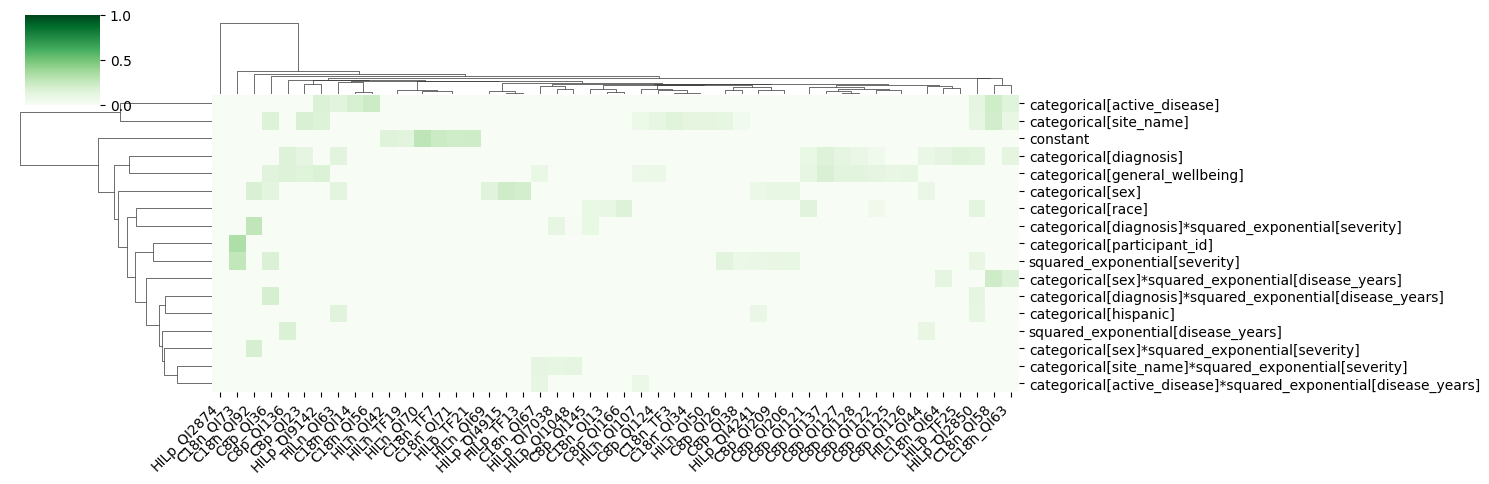

In [8]:
# Look at overall heatmap (with atleast 10% variance explained)
gps.plot_heatmap(var_cutoff=0.1, show_vals=False)
plt.show()

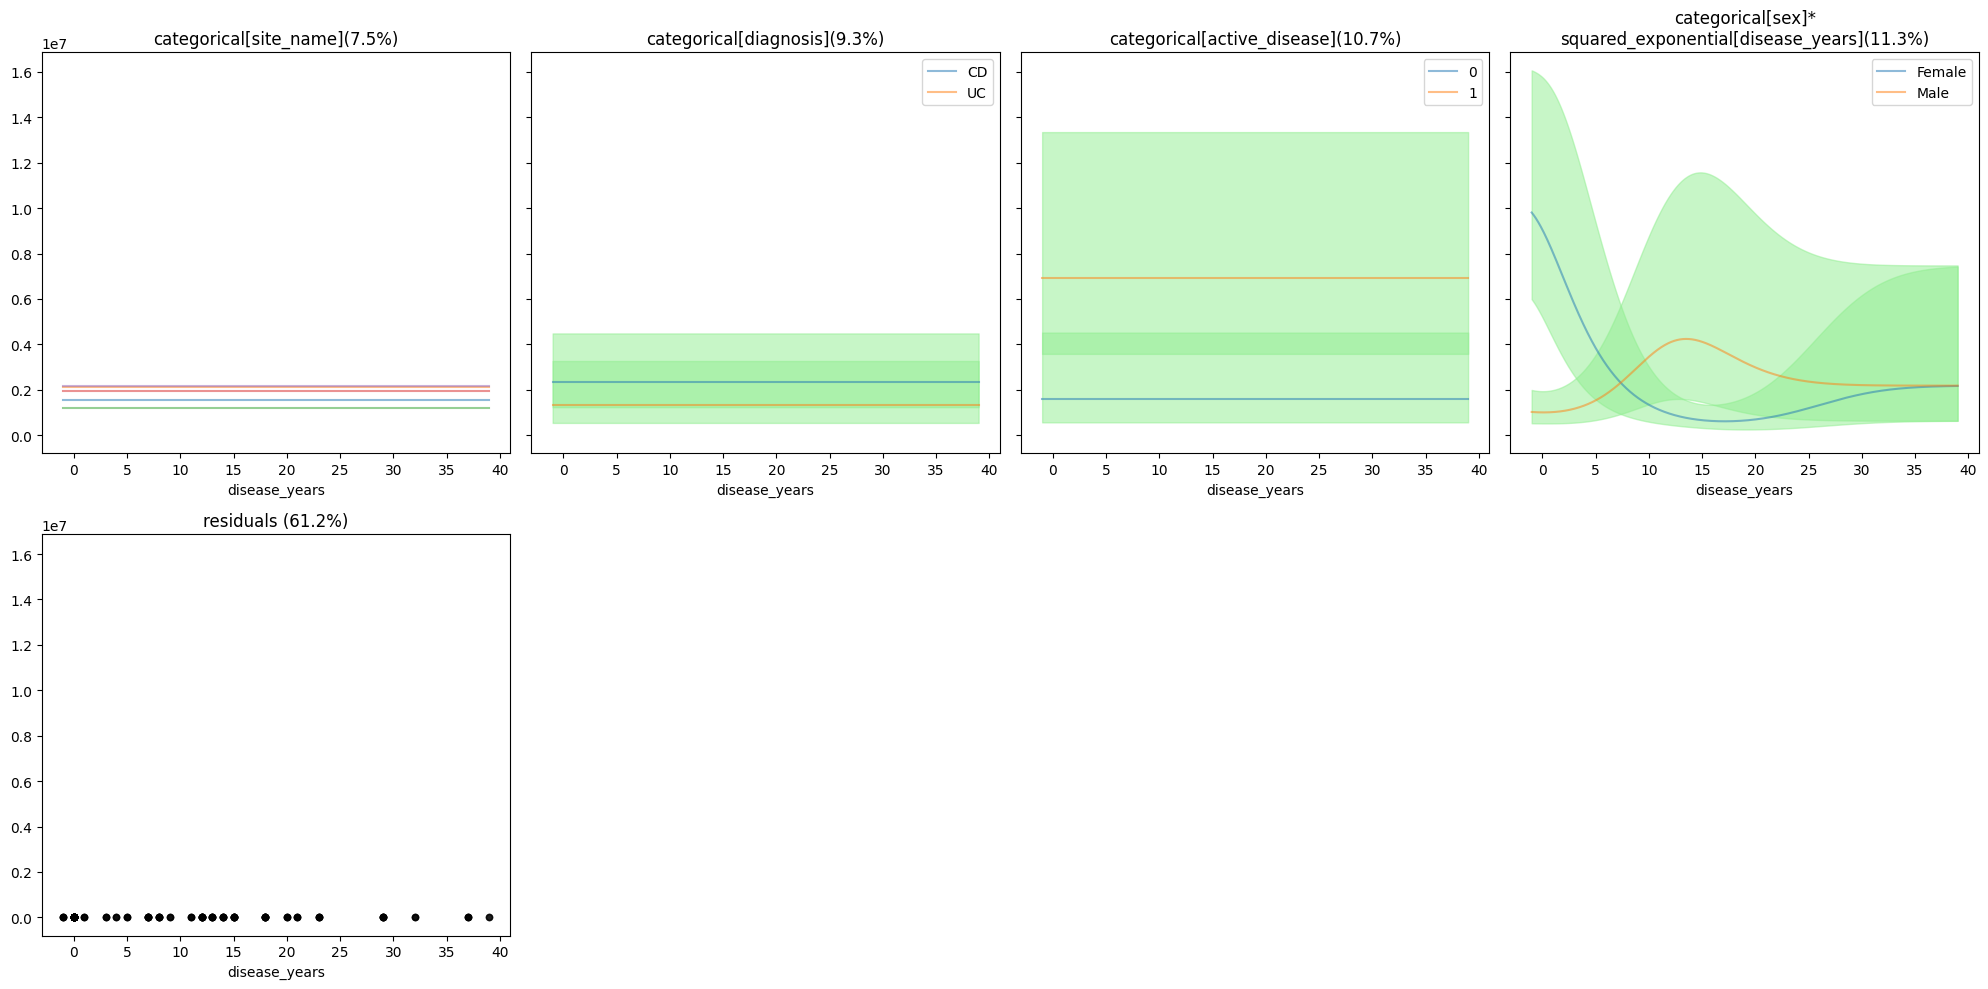

In [9]:
# Let's look at one model's components
gps.plot_parts(out_label="C18n_QI63", x_axis_label="disease_years")
plt.show()

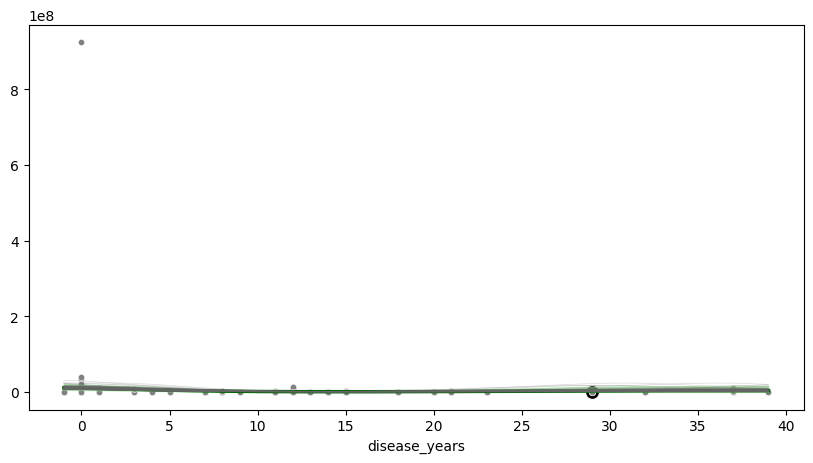

In [10]:
# Plot the GP for a given unit/individual id
gps.plot_marginal(
    out_label="C18n_QI63",
    x_axis_label="disease_years",
    unit_label=1 # This corresponds to participant_id = "C3002"
    # Which can be seen by looking at gps.categorical_dict["participant_id"]
)
plt.show()

Let's look at another metabolite that has a large amount of variance explained by the model/kernel components.

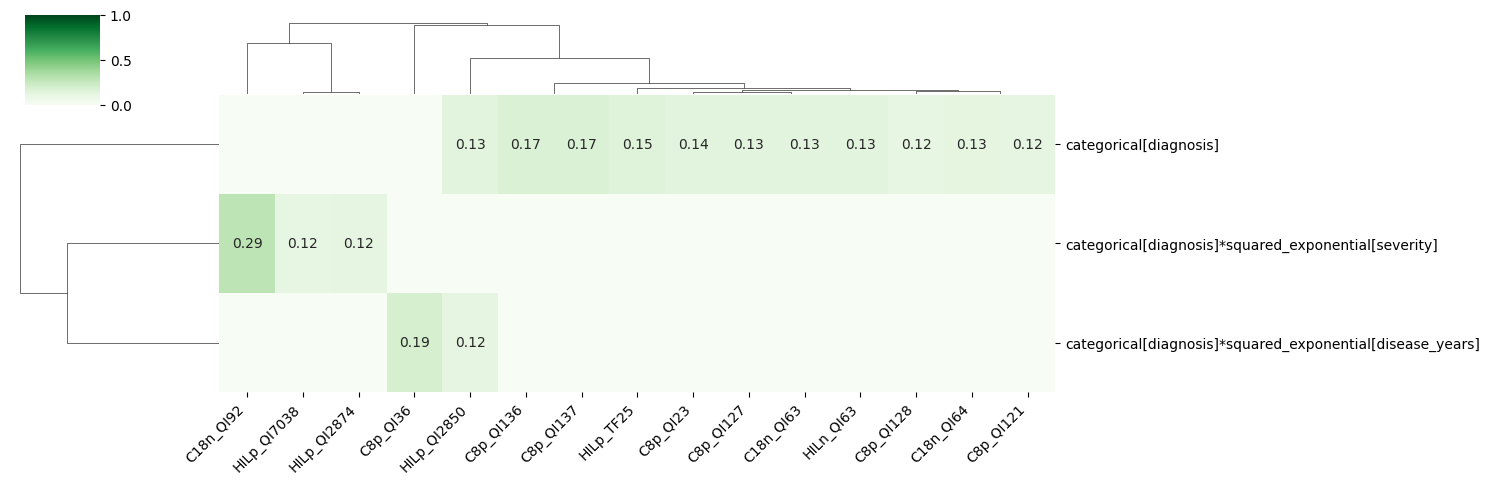

In [11]:
# Look at heatmap for most explainable metabolite
gps.plot_heatmap(feature_name="diagnosis", var_cutoff=0.1)

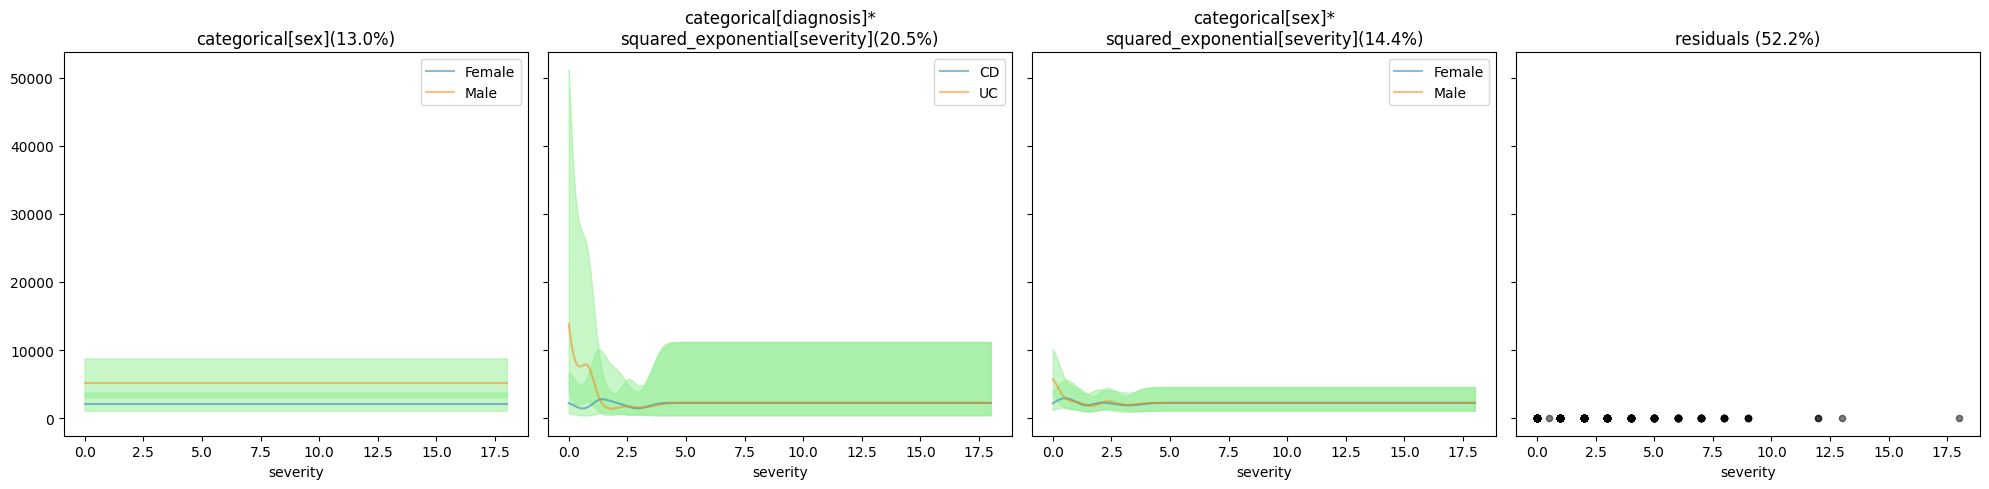

In [12]:
# Let's look at the metabolite that seems to be associated with diagnosis x age at diagnosis
gps.plot_parts(
    out_label="C18n_QI92",
    x_axis_label="severity"
)
plt.show()

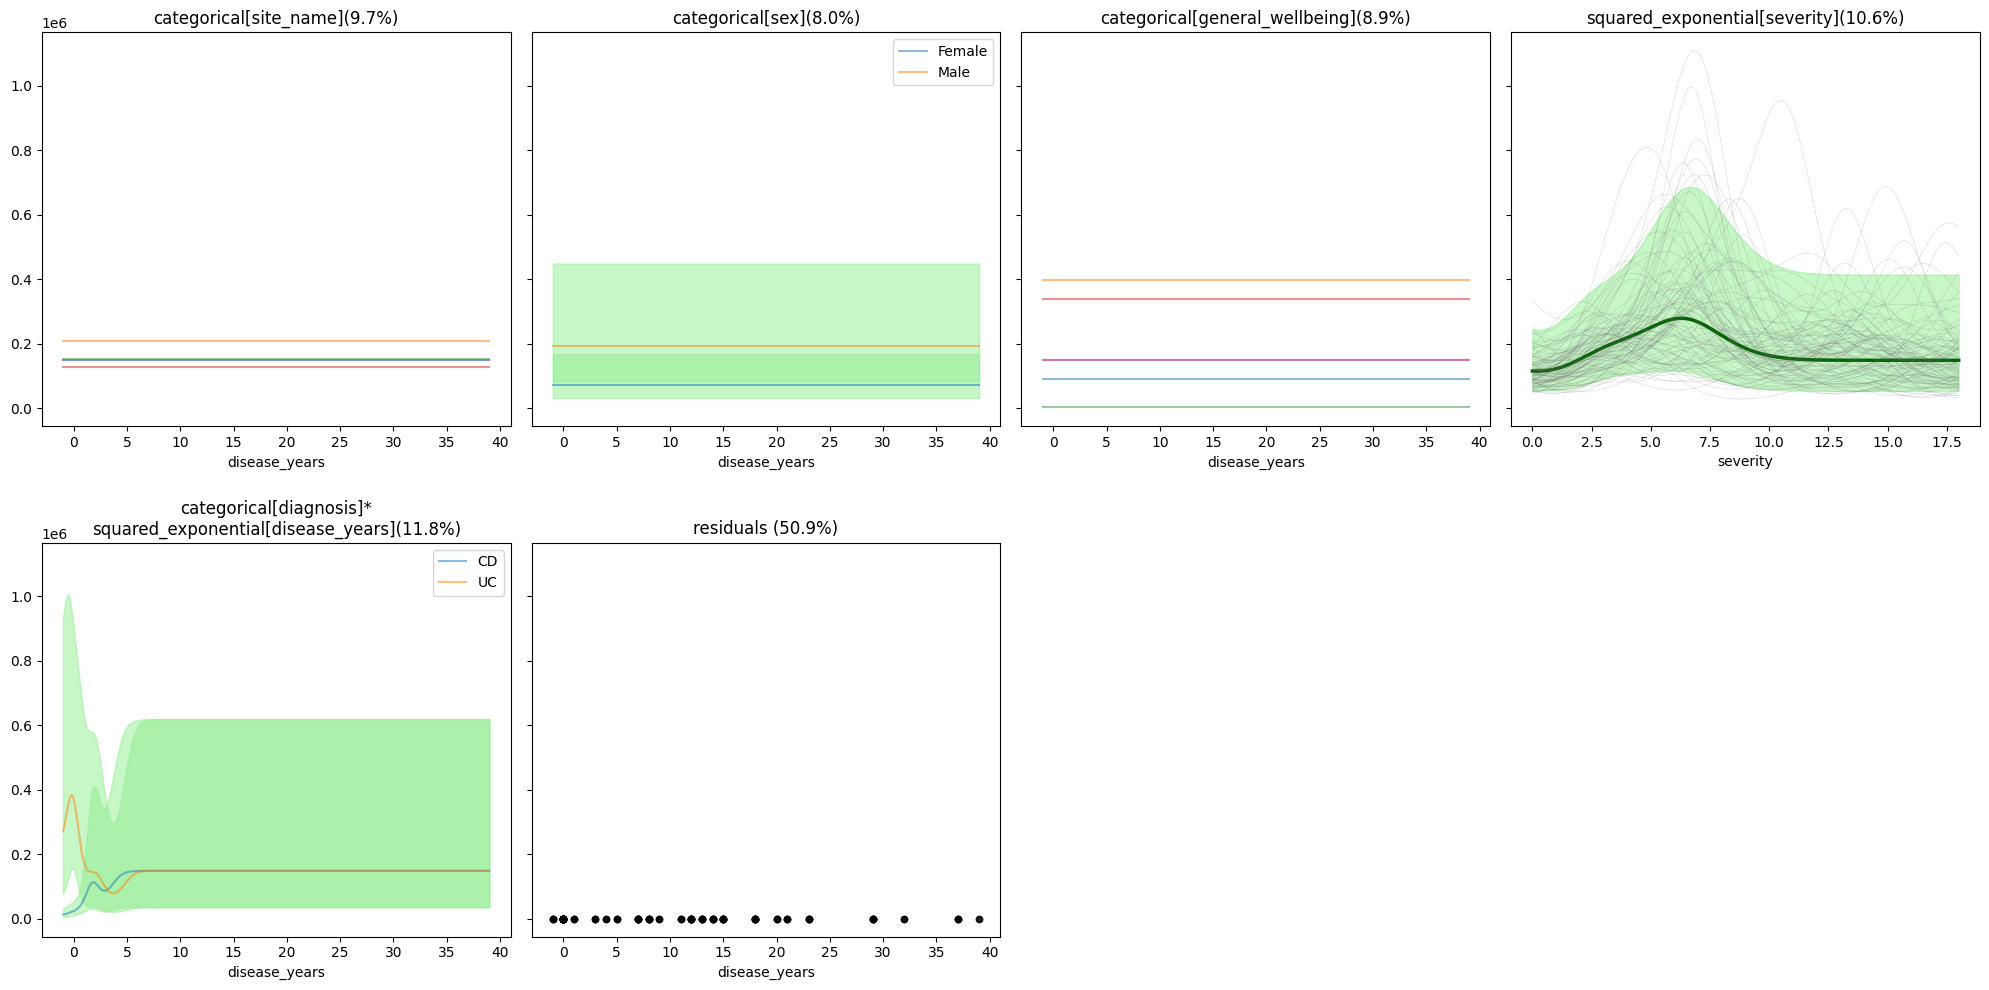

In [13]:
# Let's look at the metabolite that seems to be associated with diagnosis x age at diagnosis
gps.plot_parts(
    out_label="C8p_QI36",
    x_axis_label="disease_years"
)
plt.show()

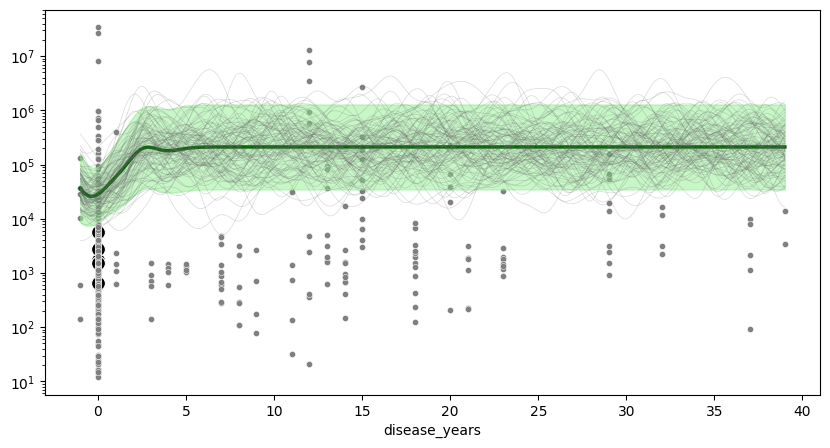

In [14]:
# Plot the GP for a given unit/individual id
gps.plot_marginal(
    out_label="C8p_QI36",
    x_axis_label="disease_years",
    unit_label=73
)
# plt.title(
#     mbx_lookup.query(f"Compound == '{compound_tag2}'")["Metabolite"].values[0]
#     + f" for participant {gps.categorical_dict['participant_id'][1][unit_index]}"
# )
plt.yscale("log")
plt.show()